# Approach 2 Investigation

In [42]:
import psycopg2 as pg
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

### Get the train/dev data from the database

#### Approach2: Training data is all regular season data (2003-2018)

In [4]:
approach2TrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') AND (f."Season" < 2019) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2_training = pd.read_sql_query(approach2TrainingDataQuery, conn)

#### Approach2: Dev data is all tournament data (2003-2017)

In [5]:
approach2DevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2002) order by "Season", "DayNum", "Team" '''
df_approach2_dev = pd.read_sql_query(approach2DevDataQuery, conn)

#### Approach2Combined: Training data is all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [6]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

#### Approach2Combined: Dev data is tournament data between 2014-2017

In [7]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [8]:
conn.close()

### Create Train and Dev Sets

In [9]:
target = 'Outcome'
features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']

In [10]:
X_train2 = df_approach2_training[features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[features]
y_dev2  = df_approach2_dev[target]

In [11]:
X_train2_combined = df_approach2Combined_training[features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[features]
y_dev2_combined  = df_approach2Combined_dev[target]

#### Examine the number of NaNs (or Nones) in data from all regular season games

In [12]:
X_train2_counts_df = X_train2.count().to_frame().T
X_train2_nan_counts_df = X_train2.shape[0] - X_train2_counts_df

In [13]:
X_train2_nan_counts_df[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,5481,5481,5481,5481,5481,5481,5481,5481,5481,5481


In [14]:
X_train2_nan_counts_df[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,SeedDiff,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor
0,7884,7884,5481,5481,6704,5481,5481,5481,164082,5481,5481,5481


The following have 164082 'None': SeedDiff.  **We will ignore this column**

The following have 5481 NaNs: TwoPointPct_Team, ThreePointPct_Team, FreeThrowPct_Team, OffensiveRebounds_Team, DefensiveRebounds_Team, TwoPointPct_Opponent, ThreePointPct_Opponent, FreeThrowPct_Opponent, OffensiveRebounds_Opponent, DefensiveRebounds_Opponent, WinPct	OpponentWinPct, AvgPointsFor, AvgPointsAgainst, AvgNetPointsFor, OpponentAvgPointsFor, OpponentAvgPointsAgainst, OpponentAvgNetPointsFor

In [15]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_nan_counts_df['TwoPointPct_Team'])/X_train2.shape[0])

Which is: 0.03 % of the data. Since this is a small percentage, they can be removed.


The following have 7884 NaNs: AvgRank, OpponentAvgRank

In [16]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_nan_counts_df['AvgRank'])/X_train2.shape[0])

Which is: 0.05 % of the data. Since this is a small percentage, they can be removed.


#### Examine the number of NaNs (or Nones) in data from all tournament data (2003-2017)

In [17]:
X_dev2_counts_df = X_dev2.count().to_frame().T
X_dev2_nan_counts = X_dev2.shape[0] - X_dev2_counts_df

In [18]:
X_dev2_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,0,0,0,0,0,0,0,0,0,0


In [19]:
X_dev2_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,SeedDiff,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor
0,0,0,0,0,0,0,0,0,0,0,0,0


There are no 'NaN' or 'None' values for the tournament data.

#### Examine the number of NaNs (or Nones) in data from all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [20]:
X_train2_combined_counts_df = X_train2_combined.count().to_frame().T
X_train2_combined_nan_counts = X_train2_combined.shape[0] - X_train2_combined_counts_df

In [21]:
X_train2_combined_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,5481,5481,5481,5481,5481,5481,5481,5481,5481,5481


In [22]:
X_train2_combined_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,SeedDiff,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor
0,7884,7884,5481,5481,6704,5481,5481,5481,164082,5481,5481,5481


The following have 164082 'None': SeedDiff.  **We will ignore this column**

The following have 5481 NaNs: TwoPointPct_Team, ThreePointPct_Team, FreeThrowPct_Team, OffensiveRebounds_Team, DefensiveRebounds_Team, TwoPointPct_Opponent, ThreePointPct_Opponent, FreeThrowPct_Opponent, OffensiveRebounds_Opponent, DefensiveRebounds_Opponent, WinPct, OpponentWinPct, AvgPointsFor, AvgPointsAgainst, AvgNetPointsFor, OpponentAvgPointsFor, OpponentAvgPointsAgainst, OpponentAvgNetPointsFor.

In [23]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_combined_nan_counts['TwoPointPct_Team'])/X_train2_combined.shape[0])

Which is: 0.03 % of the data. Since this is a small percentage, they can be removed.


The following have 7884 NaNs: AvgRank, OpponentAvgRank

In [24]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_combined_nan_counts['AvgRank'])/X_train2_combined.shape[0])

Which is: 0.05 % of the data. Since this is a small percentage, they can be removed.


#### Examine the number of NaNs (or Nones) in data from tournament data between 2014-2017

In [25]:
X_dev2_combined_counts_df = X_dev2_combined.count().to_frame().T
X_dev2_combined_nan_counts = X_dev2_combined.shape[0] - X_dev2_combined_counts_df

In [26]:
X_dev2_combined_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,0,0,0,0,0,0,0,0,0,0


In [27]:
X_dev2_combined_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,SeedDiff,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor
0,0,0,0,0,0,0,0,0,0,0,0,0


There are no 'NaN' or 'None' values for the tournament data.

### Remove the NaN values

In [28]:
rows_to_drop = (np.isnan(df_approach2_training.Outcome)) | (np.isnan(df_approach2_training.TwoPointPct_Team)) | (np.isnan(df_approach2_training.ThreePointPct_Team)) | (np.isnan(df_approach2_training.FreeThrowPct_Team)) | (np.isnan(df_approach2_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2_training.AvgRank)) | (np.isnan(df_approach2_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [29]:
df_approach2_training = df_approach2_training.drop(df_approach2_training[rows_to_drop].index)

In [30]:
rows_to_drop = (np.isnan(df_approach2_dev.Outcome)) | (np.isnan(df_approach2_dev.TwoPointPct_Team)) | (np.isnan(df_approach2_dev.ThreePointPct_Team)) | (np.isnan(df_approach2_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2_dev.AvgRank)) | (np.isnan(df_approach2_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [31]:
df_approach2_dev = df_approach2_dev.drop(df_approach2_dev[rows_to_drop].index)

In [32]:
rows_to_drop = (np.isnan(df_approach2Combined_training.Outcome)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.AvgRank)) | (np.isnan(df_approach2Combined_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [33]:
df_approach2Combined_training = df_approach2Combined_training.drop(df_approach2Combined_training[rows_to_drop].index)

In [34]:
rows_to_drop = (np.isnan(df_approach2Combined_dev.Outcome)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.AvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor))

In [35]:
df_approach2Combined_dev = df_approach2Combined_dev.drop(df_approach2Combined_dev[rows_to_drop].index)

#### Check the 'Outcome' types:

In [36]:
print df_approach2_training['Outcome'].dtype
print df_approach2_dev['Outcome'].dtype
print df_approach2Combined_training['Outcome'].dtype
print df_approach2Combined_dev['Outcome'].dtype

int64
float64
int64
float64


The 'Outcome' type needs to be of type 'int', so the float values need to be casted to int.

Also remove any features (for example, SeedDiff):

In [37]:
reduced_features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor']

In [38]:
X_train2 = df_approach2_training[reduced_features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[reduced_features]
# Cast to 'int'
y_dev2  = df_approach2_dev[target].astype(int)

In [39]:
X_train2_combined = df_approach2Combined_training[reduced_features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[reduced_features]
# Cast to 'int'
y_dev2_combined  = df_approach2Combined_dev[target].astype(int)

### Logistic Regression

Perform a Logistic Regression (Lasso) Using the **Regular Season**

In [40]:
lrc1 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv1 = GridSearchCV(lrc1, params, scoring='accuracy', refit=True)
gscv1.fit(X_train2, y_train2)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv1.best_score_, gscv1.best_params_['C']))

Best accuracy: 0.7101, with best C: 200


In [45]:
lrc1 = LogisticRegression(penalty='l1', C=gscv1.best_params_['C'])
lrc1.fit(X_train2, y_train2)
prediction1 = lrc1.predict(X_dev2)
print classification_report(prediction1, y_dev2)

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       981
          1       0.72      0.72      0.72       981

avg / total       0.72      0.72      0.72      1962



Area under the curve: 0.715


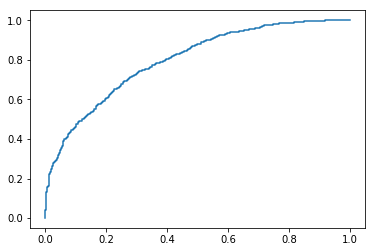

In [76]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc1.predict(X_dev2)))

y_probas = lrc1.predict_proba(X_dev2)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Perform a Logistic Regression (Ridge) Using the **Regular Season**

In [47]:
lrc2 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv2 = GridSearchCV(lrc2, params, scoring='accuracy', refit=True)
gscv2.fit(X_train2, y_train2)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv2.best_score_, gscv2.best_params_['C']))

Best accuracy: 0.7105, with best C: 175


In [49]:
lrc2 = LogisticRegression(penalty='l2', C=gscv2.best_params_['C'])
lrc2.fit(X_train2, y_train2)
prediction2 = lrc2.predict(X_dev2)
print classification_report(prediction2, y_dev2)

             precision    recall  f1-score   support

          0       0.71      0.72      0.71       980
          1       0.72      0.71      0.72       982

avg / total       0.72      0.72      0.72      1962



Area under the curve: 0.715


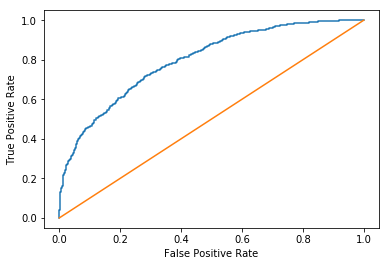

In [50]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc2.predict(X_dev2)))

y_probas = lrc2.predict_proba(X_dev2)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Perform a Logistic Regression (Lasso) Using **Combined Regular Season / Tournament Data**

In [51]:
lrc3 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv3 = GridSearchCV(lrc3, params, scoring='accuracy', refit=True)
gscv3.fit(X_train2_combined, y_train2_combined)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv3.best_score_, gscv3.best_params_['C']))

Best accuracy: 0.7103, with best C: 200


In [52]:
lrc3 = LogisticRegression(penalty='l1', C=gscv3.best_params_['C'])
lrc3.fit(X_train2_combined, y_train2_combined)
prediction3 = lrc3.predict(X_dev2_combined)
print classification_report(prediction3, y_dev2_combined)

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       268
          1       0.73      0.73      0.73       268

avg / total       0.73      0.73      0.73       536



Area under the curve: 0.715


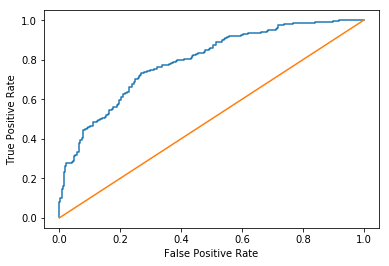

In [53]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc3.predict(X_dev2)))

y_probas = lrc3.predict_proba(X_dev2_combined)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2_combined.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Perform a Logistic Regression (Ridge) Using **Combined Regular Season / Tournament Data**

In [54]:
lrc4 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv4 = GridSearchCV(lrc4, params, scoring='accuracy', refit=True)
gscv4.fit(X_train2_combined, y_train2_combined)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv4.best_score_, gscv4.best_params_['C']))

Best accuracy: 0.7106, with best C: 50


In [55]:
lrc4 = LogisticRegression(penalty='l2', C=gscv4.best_params_['C'])
lrc4.fit(X_train2_combined, y_train2_combined)
prediction4 = lrc4.predict(X_dev2_combined)
print classification_report(prediction4, y_dev2_combined)

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       268
          1       0.73      0.73      0.73       268

avg / total       0.73      0.73      0.73       536



Area under the curve: 0.716


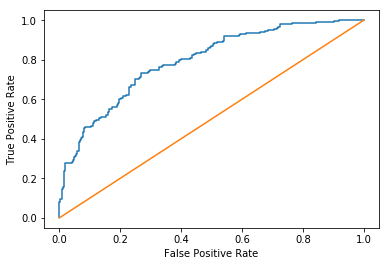

In [56]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc4.predict(X_dev2)))

y_probas = lrc4.predict_proba(X_dev2_combined)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2_combined.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Look for the most influential features
https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model

#### Regular Season

In [62]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': np.abs(np.std(X_train2) * lrc1.coef_[0])
    })

importance_df.sort_values(by='importance', ascending=False)

,feature,importance
OpponentAvgRank,OpponentAvgRank,1.010406
AvgRank,AvgRank,1.010399
OpponentAvgNetPointsFor,OpponentAvgNetPointsFor,0.491198
AvgNetPointsFor,AvgNetPointsFor,0.486072
WinPctDiff,WinPctDiff,0.355366
DefensiveRebounds_Team,DefensiveRebounds_Team,0.066682
DefensiveRebounds_Opponent,DefensiveRebounds_Opponent,0.066522
TwoPointPct_Opponent,TwoPointPct_Opponent,0.061253
TwoPointPct_Team,TwoPointPct_Team,0.061041
OffensiveRebounds_Opponent,OffensiveRebounds_Opponent,0.053782


#### Combined Regular Season / Tournament

In [63]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': np.abs(np.std(X_train2_combined) * lrc3.coef_[0])
    })

importance_df.sort_values(by='importance', ascending=False)

,feature,importance
OpponentAvgRank,OpponentAvgRank,1.018688
AvgRank,AvgRank,1.018470
AvgNetPointsFor,AvgNetPointsFor,0.497093
OpponentAvgNetPointsFor,OpponentAvgNetPointsFor,0.471083
WinPctDiff,WinPctDiff,0.356818
DefensiveRebounds_Opponent,DefensiveRebounds_Opponent,0.066711
DefensiveRebounds_Team,DefensiveRebounds_Team,0.066224
TwoPointPct_Team,TwoPointPct_Team,0.062978
TwoPointPct_Opponent,TwoPointPct_Opponent,0.061888
OffensiveRebounds_Team,OffensiveRebounds_Team,0.056133
